# Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -r sample_data

In [3]:
!pip install timm

     |████████████████████████████████| 431 kB 7.4 MB/s 


In [4]:
# !pip install albumentations==0.4.6

# Libraries

In [5]:
import torch
import timm
import pandas as pd
import os
import cv2
import numpy as np

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

# csv

In [6]:
PATH = "/content/drive/MyDrive/ISIC/2016"
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data']

In [7]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)

In [8]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0

def to_path_train(image_name):
  return train_path +image_name+'.jpg'

def to_path_test(image_name):
  return test_path +image_name+'.jpg'
train['target'] = train.benign_malignant.apply(to_int)
train['path'] = train.image_name.apply(to_path_train)

test['path'] = test.image_name.apply(to_path_test)

In [9]:
import numpy as np
from sklearn import model_selection
FOLDS = 3
kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold_, (train_idx, test_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[test_idx,'kfold'] = fold_

  train_fold = train.iloc[train_idx]
  val_fold = train.iloc[test_idx]
  train_fold.reset_index(drop=True, inplace=True)
  val_fold.reset_index(drop=True, inplace=True)
  train_fold.to_csv(f'./train_fold{FOLDS}.csv')
  val_fold.to_csv(f'./val_fold{FOLDS}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, test_idx.shape)

Fold: 1
(600,) (300,)
Fold: 2
(600,) (300,)
Fold: 3
(600,) (300,)


# Dataset class

In [29]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 10,
}

In [11]:
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize

import cv2
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      image = self.transform(image=image)["image"].astype(np.float32)
    else:
      image = image.astype(np.float32)/ 255.0
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  # def __getitem__(self, ix):
  #   img = io.imread(self.images[ix])
  #   img = resize(img,(224,224))
  #   image = torch.from_numpy(img).float()
  #   if self.transform is not None:
  #     image = self.transform(image=image)["image"].astype(np.float32)
  #   else:
  #     img = img.transpose(2, 0, 1)
  #   if self.train:
  #     target = torch.tensor([self.labels[ix]]).float()
  #     return image, target
  #   return image
        
  def __len__(self) -> int:
    return len(self.images)

# Data Loader

In [ ]:
from torch.utils.data import DataLoader
dataset = {
    'train': MelanomaDataset(train_fold['path'], train_fold['target']),
    'val': MelanomaDataset(val_fold['path'], val_fold['target'])
}

In [ ]:
BATCH=128
train_loader = DataLoader(dataset['train'], batch_size=BATCH, shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=BATCH)

## print raw datasets

In [ ]:
dataset['train'][0][1]

tensor([1.])

In [ ]:
print(dataset['train'][0][0].shape)
dataset['train'][0][0]

torch.Size([3, 224, 224])


tensor([[[0.0549, 0.0275, 0.0118,  ..., 0.0118, 0.0078, 0.0275],
         [0.0314, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0000],
         [0.0275, 0.0314, 0.0196,  ..., 0.0196, 0.0235, 0.0196],
         ...,
         [0.0471, 0.0431, 0.0431,  ..., 0.0941, 0.0863, 0.0745],
         [0.0353, 0.0667, 0.0314,  ..., 0.0902, 0.0745, 0.0510],
         [0.0314, 0.0235, 0.0392,  ..., 0.0863, 0.0627, 0.0667]],

        [[0.0549, 0.0275, 0.0118,  ..., 0.0118, 0.0078, 0.0275],
         [0.0314, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0000],
         [0.0275, 0.0314, 0.0196,  ..., 0.0196, 0.0235, 0.0196],
         ...,
         [0.0471, 0.0431, 0.0431,  ..., 0.1529, 0.1176, 0.0824],
         [0.0353, 0.0667, 0.0314,  ..., 0.1294, 0.0941, 0.0667],
         [0.0314, 0.0235, 0.0392,  ..., 0.1137, 0.0902, 0.0902]],

        [[0.0549, 0.0275, 0.0118,  ..., 0.0118, 0.0078, 0.0275],
         [0.0314, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0000],
         [0.0275, 0.0314, 0.0196,  ..., 0.0196, 0.0235, 0.

In [ ]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 1]))

# Show batch

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

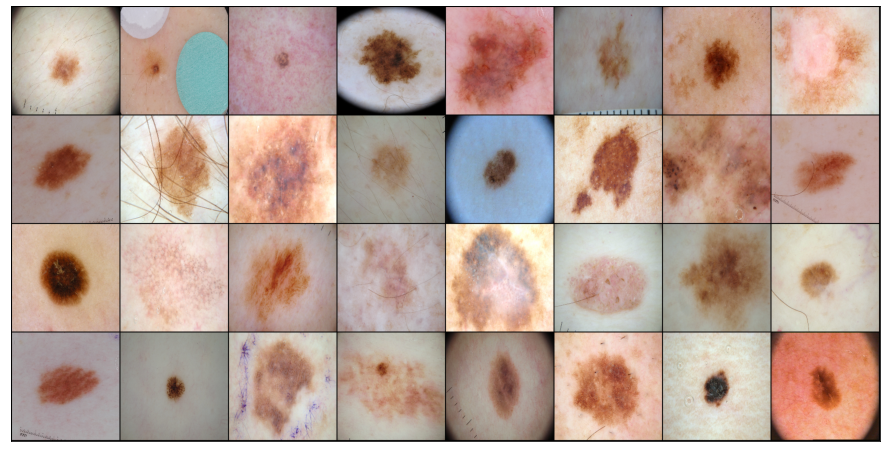

In [ ]:
show_batch(train_loader)

# Generate mean and std from dataset
mean: (0.72196096, 0.6170128, 0.56728417) \\
std: (0.16372901, 0.17203921, 0.19337493)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      # Mean over batch, height and width, but not over the channels
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(dataset['train']))
print(mean)
print(std)

## compute_img_mean_std function (not used)

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    print(f'mean {means}')
    print(f'std {stds}')
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

# Augmentation

In [12]:
mean= (0.72196096, 0.6170128, 0.56728417)
std= (0.16372901, 0.17203921, 0.19337493)

In [13]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(im_size, im_size),
       A.Cutout(max_h_size=int(im_size * 0.375), max_w_size=int(im_size * 0.375), num_holes=1, p=0.7),
       A.Normalize(mean,std)
       ])
  
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Normalize(mean, std)
       ])
  return transforms_train, transforms_val

In [14]:
# import albumentations as A

# train_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.Normalize(mean, std)
#     ]
# )

# val_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.CenterCrop(height=128, width=128),
#         A.Normalize(mean, std)
#     ]
# )

In [32]:
from torch.utils.data import DataLoader
transforms_train, transforms_val = transform_aug(224)

dataset_aug = {
    'train': MelanomaDataset(train_fold['path'], train_fold['target'],transform=transforms_train),
    'val': MelanomaDataset(val_fold['path'], val_fold['target'],transform=transforms_val)
}

train_loader = DataLoader(dataset_aug['train'], batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset_aug['val'], batch_size=params['batch_size'])

images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 224, 224, 3]), torch.Size([128, 1]))

## Visualize augmentation

In [18]:
import random
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image/255.)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

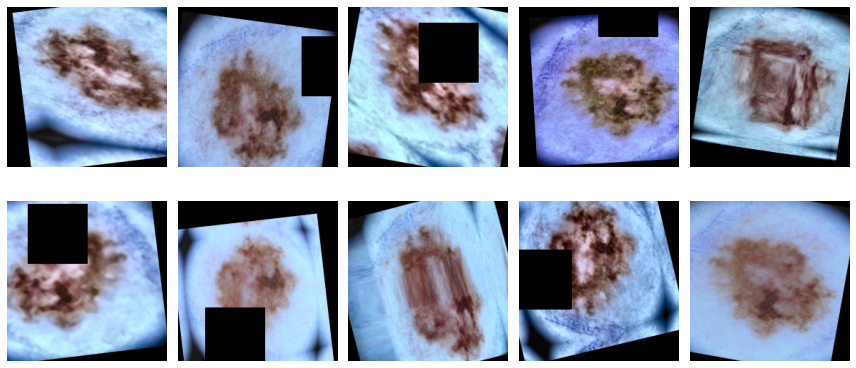

In [19]:
import matplotlib.pyplot as plt
random.seed(42)
visualize_augmentations(dataset_aug['train'])

# Model

In [20]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
        # self.model.fc = nn.Linear(in_features=net.fc.in_features, out_features=2, bias=True)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
model = MelanomaClassifier('resnest14d',n_class=1,pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest14-9c8fe254.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest14-9c8fe254.pth


## parameters

In [22]:
from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

optimizer = AdamP(model.parameters(), lr=params['lr'])
criterion = BinaryCrossEntropy()

## Learning rate scheduler | Early stopping

In [23]:
from timm.scheduler.plateau_lr import PlateauLRScheduler

class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=3, threshold=1e-6, mode="min", warmup_t=10, warmup_lr_init=0.0002):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.threshold = threshold
    self.mode = mode
    self.warmup_t = warmup_t
    self.warmup_lr_init = warmup_lr_init
    self.lr_scheduler = scheduler = PlateauLRScheduler(self.optimizer,patience_t=self.patience_t,threshold=self.threshold, mode=self.mode, warmup_t=self.warmup_t, warmup_lr_init=self.warmup_lr_init)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

#### Visualization of the learning rate reduction per epoch

In [ ]:
def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler.get_epoch_values(epoch))
    return lr_per_epoch

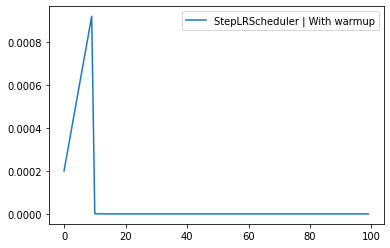

In [ ]:
from timm.scheduler.step_lr import StepLRScheduler
num_epoch = 100
scheduler = StepLRScheduler(optimizer, decay_t = num_epoch/100, decay_rate=.5, warmup_t=num_epoch/10, warmup_lr_init=num_epoch/500000)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="StepLRScheduler | With warmup");
plt.legend();

In [ ]:
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

### Early stopping

In [24]:
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# Metric

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

def auc_score(outputs, targets):
  outputs = torch.sigmoid(outputs)
  outputs = outputs.numpy().cpu()
  targets = targets.numpy().cpu()
  auc = roc_auc_score(targets, outputs)
  return auc

def f1_score(outputs, targets):
  outputs = torch.sigmoid(outputs)
  outputs = outputs.numpy().cpu()
  targets = targets.numpy().cpu()
  f1 = f1_score(targets, outputs)
  return f1

def accuracy_score(output, target):
  output = torch.sigmoid(output) >= 0.5
  target = target == 1.0
  return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

# Train

In [26]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [27]:
def train(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)
  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
    outputs = model(images)
    loss = criterion(outputs, targets)
    accuracy = accuracy_score(outputs, targets)
    auc = auc_score(outputs, targets)
    # scheduler.step(auc)

    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("AUC", auc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))

In [28]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      outputs = model(images)
      loss = criterion(outputs, targets)
      accuracy = accuracy_score(outputs, targets)
      auc = auc_score(outputs, targets)

      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("Accuracy", auc)
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
  if auc > best_auc:
    best_auc = auc
    # torch.save(model, f'{PATH}/model.pth')
    torch.save(model, 'model.pth')
    print(f"Current best model: {auc:.5f}")



In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
del variables
gc.collect()

In [1]:
from tqdm import tqdm
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

## args

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
args = vars(parser.parse_args())

In [ ]:
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'model'
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRSchedulerPlateau(optimizer)
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

In [ ]:
# training function
def fit(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    stream = tqdm(train_dataloader)
    for i, data in enumerate(stream, start=1):
        counter += 1
        data, target = data[0].to(params['device']), data[1].to(params['device'])
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

# Validation

In [ ]:
# validation function
def validate(model, test_dataloader, val_dataset, criterion):
  print('Validating')
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0
  counter = 0
  total = 0
  stream = tqdm(test_dataloader)
  with torch.no_grad():
    for _, data in enumerate(stream, start=1):
      counter += 1
      data, target = data[0].to(params['device']), data[1].to(params['device'])
      total += target.size(0)
      outputs = model(data)
      loss = criterion(outputs, target)
            
      val_running_loss += loss.item()
      _, preds = torch.max(outputs.data, 1)
      val_running_correct += (preds == target).sum().item()
      
      val_loss = val_running_loss / counter
      val_accuracy = 100. * val_running_correct / total
      return val_loss, val_accuracy

# Training loop

In [2]:
import time
from tqdm import tqdm
epochs=10
# lists to store per-epoch loss and accuracy values
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()

lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(
        model, train_loader, dataset['train'], optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_loader, dataset['val'], criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    # if args['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
    # if args['early_stopping']:
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
      break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

In [ ]:
print('Saving loss and accuracy plots...')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"../outputs/{acc_plot_name}.png")
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"../outputs/{loss_plot_name}.png")
plt.show()
    
# serialize the model to disk
print('Saving model...')
torch.save(model.state_dict(), f"../outputs/{model_name}.pth")
 
print('TRAINING COMPLETE')